<a href="https://colab.research.google.com/github/amjadseyedi/NMFcUDA/blob/main/NMF_CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google Drive in Colab

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Clone the NMFcUDA repository and change directory into it

In [ ]:
!git clone https://github.com/amjadseyedi/NMFcUDA.git
%cd NMFcUDA

Cloning into 'NMFcUDA'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 821.15 KiB | 16.76 MiB/s, done.
/content/NMFcUDA/NMFcUDA


### PyTorch GPU/CPU Device Setup
Tip: You can enable GPU support in Colab by going to
"Runtime" > "Change runtime type" > "Hardware accelerator" > "GPU"

In [ ]:
import os
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu_index = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(gpu_index)
    print(torch.cuda.device_count(), f"x {gpu_name}")
else:
    print("CPU")

1 x Tesla T4


# NMF β-divergence

$D_{\beta}(X,WH) =\sum_{i,j} D_{\beta} (X_{i,j},[WH]_{i,j})$
$\quad\quad
W \leftarrow W \circ \frac{(X\circ(WH)^{\beta-2})H^\top}{(WH)^{\beta - 1} H^{\top}},\quad
H \leftarrow H \circ
\frac{ W^{\top} ( X \circ (WH)^{\beta - 2} ) }
     { W^{\top} (WH)^{\beta - 1}}
$



## NMF function

In [ ]:
from tqdm import trange

def beta_divergence(X, WH, beta):
    eps = 1e-10
    if beta == 2:  # Euclidean
        return torch.sum((X - WH) ** 2) / 2
    elif beta == 1:  # KL
        return torch.sum(X * torch.log((X + eps) / (WH + eps)) - X + WH)
    elif beta == 0:  # Itakura–Saito
        return torch.sum((X / (WH + eps)) - torch.log((X + eps) / (WH + eps)) - 1)
    else:  # General beta
        return (1 / (beta * (beta - 1))) * torch.sum(
            X**beta + (beta - 1) * WH**beta - beta * X * WH ** (beta - 1)
        )

def nmf_beta(X, r, beta=2, iters=500, device="cpu"):
    """
    NMF with beta-divergence using multiplicative update rules.

    Args:
        X: (m x n) nonnegative input matrix (torch.Tensor).
        r: rank (int).
        beta: beta-divergence parameter (float).
              beta=2 -> Euclidean
              beta=1 -> KL
              beta=0 -> Itakura–Saito
        iters: number of iterations (int).
        device: "cpu" or "cuda".
    Returns:
        W (m x r), H (r x n)
    """
    m, n = X.shape
    X = X.to(device)

    W = torch.rand(m, r, dtype=torch.float32, device=device)
    H = torch.rand(r, n, dtype=torch.float32, device=device)

    eps = 1e-10
    error = []
    for t in trange(iters, desc="NMF training", unit="iter"):
        WH = W @ H + eps

        W *= ((X * WH**(beta - 2)) @ H.T) / (WH**(beta - 1) @ H.T + eps)
        WH = W @ H + eps
        H *= (W.T @ (X * WH**(beta - 2))) / (W.T @ (WH**(beta - 1)) + eps)

        err = beta_divergence(X, WH, beta).item()/beta_divergence(X, torch.mean(X) * torch.ones_like(X), beta).item()
        error.append(err)

        # if (t + 1) % 100 == 0:
        #     print(f"Iter {t+1}/{iters}, Error: {err:.4f}")

    return W, H, error

### Run on the CBCL dataset

NMF training: 100%|██████████| 1000/1000 [00:01<00:00, 639.86iter/s]


Total NMF time: 1.57 seconds


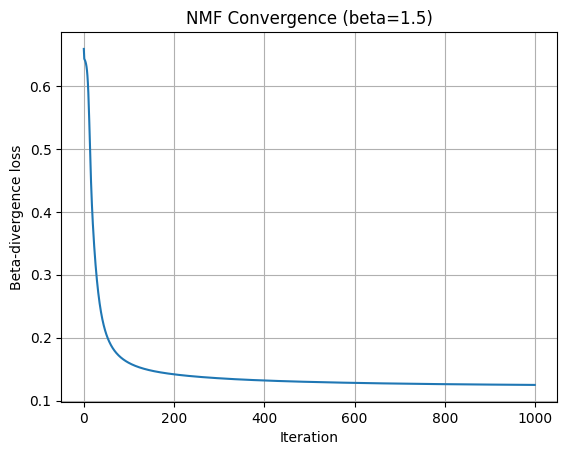

In [ ]:
import time
from scipy.io import loadmat
import matplotlib.pyplot as plt

X_np = loadmat('CBCL.mat')['X']

X = torch.tensor(X_np, dtype=torch.float32, device=device)
m, n = X.shape

r = 49
beta = 1.5
iters = 1000

start = time.time()
W, H, error = nmf_beta(X, r, beta, iters, device)
end = time.time()
print(f"Total NMF time: {end - start:.2f} seconds")
plt.plot(error)
plt.xlabel("Iteration")
plt.ylabel("Beta-divergence loss")
plt.title(f"NMF Convergence (beta={beta})")
plt.grid(True)
plt.show()

### Visualize basis matrix

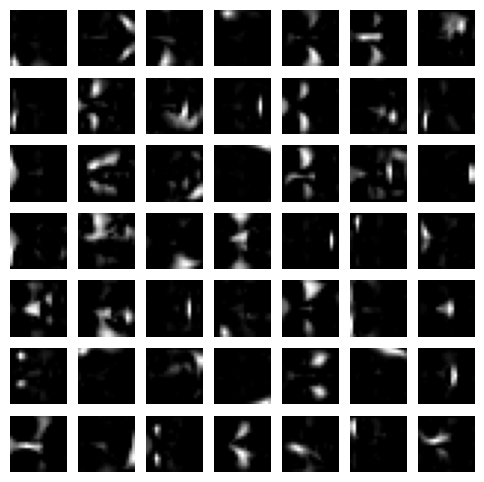

In [ ]:
w = W.view(19, 19, 7, 7).cpu().detach().numpy()

fig, axes = plt.subplots(7, 7, figsize=(6, 6))

for i in range(7):
    for j in range(7):
        axes[i, j].imshow(w[:, :, i, j], cmap='gray')
        axes[i, j].axis('off')

plt.show()